# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-04-22/data_eval_new/"
file_name = "int_norm_20160422_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

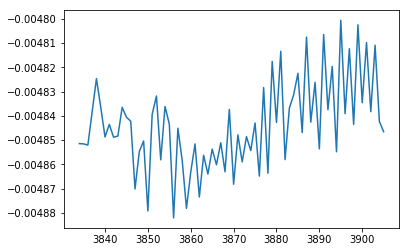

In [9]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

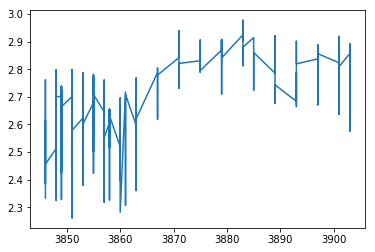

In [13]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [14]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['200ppb NIST Sn Std', 'NIST 200ppb', 'NIST 350ppb',
       'ZH09-05 23.3_1_3', 'ZH09-05 44.8_1_2', 'DTS-2B bomb1+2  Sn1',
       'NIST + Cd ns 1', 'mixed sample'], dtype=object)

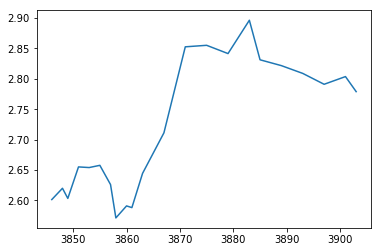

In [15]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

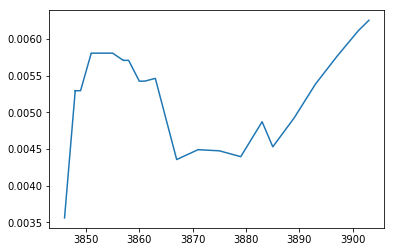

In [17]:
# Check background 
column = "120"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [18]:
background_mean = df_mean(background)

In [19]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [20]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [145]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [146]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [147]:
column = "124/120"
sample = "NIST 200ppb"

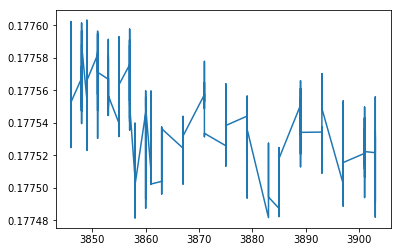

In [148]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [149]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [150]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2016-04-22 11:34:00,200ppb NIST Sn Std,2,1,3838,0.029826,0.020196,0.010355,0.446010,0.235290,0.742935,0.263455,0.142084,0.177565
2016-04-22 11:34:00,200ppb NIST Sn Std,2,2,3838,0.029815,0.020186,0.010357,0.445950,0.235280,NaN,0.263433,0.142097,0.177571
2016-04-22 11:34:00,200ppb NIST Sn Std,2,3,3838,0.029815,0.020187,0.010357,0.445988,0.235297,NaN,0.263441,0.142082,0.177570
2016-04-22 11:34:00,200ppb NIST Sn Std,2,4,3838,0.029815,0.020183,0.010359,0.445962,0.235284,0.742935,0.263435,0.142094,0.177583
2016-04-22 11:34:00,200ppb NIST Sn Std,2,5,3838,0.029811,0.020189,0.010356,0.445976,0.235279,0.742935,0.263439,0.142097,0.177578
2016-04-22 11:34:00,200ppb NIST Sn Std,2,6,3838,0.029813,0.020181,0.010358,0.445958,0.235293,0.742935,0.263432,0.142080,0.177551
2016-04-22 11:34:00,200ppb NIST Sn Std,2,7,3838,0.029810,0.020183,0.010361,0.446001,0.235282,NaN,0.263474,0.142104,0.177600
2016-04-22 11:34:00,200ppb NIST Sn Std,2,8,3838,0.029816,0.020192,0.010356,0.445980,0.235296,NaN,0.263460,0.142093,0.177574
2016-04-22 11:34:00,200ppb NIST Sn Std,2,9,3838,0.029814,0.020181,0.010359,0.445972,0.235292,0.742935,0.263442,0.142086,0.177561


In [151]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
3840        2016-04-22 12:01:00    0.177534
3845        2016-04-22 13:09:00    0.177522
3865        2016-04-22 20:50:00    0.177477
3895        2016-04-23 04:34:00    0.177513
3901        2016-04-23 06:07:00    0.177550
            2016-04-23 06:07:00    0.177494
Name: 124/120, dtype: float64

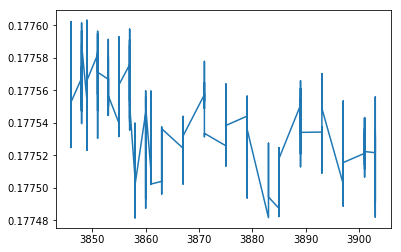

In [152]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [153]:
df[df["Sample"] == sample][column].std()

2.4964253423056737e-05

In [154]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [155]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

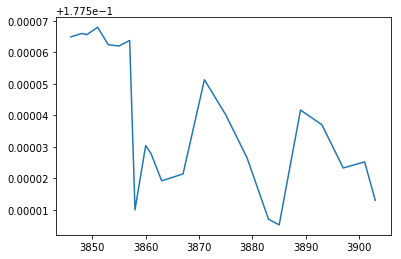

In [156]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [157]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2016-04-22 11:34:00,3838,200ppb NIST Sn Std,0.029817,0.020186,0.010360,0.445984,0.235294,0.742935,0.263449,0.142089,0.177566,0.000241,0.000032
2016-04-22 11:48:00,3839,200ppb NIST Sn Std,0.029821,0.020189,0.010362,0.445994,0.235301,0.742935,0.263454,0.142088,0.177565,0.000228,0.000027
2016-04-22 12:01:00,3840,200ppb NIST Sn Std,0.029820,0.020188,0.010364,0.445988,0.235300,0.742935,0.263454,0.142091,0.177568,0.000235,0.000028
2016-04-22 12:15:00,3841,200ppb NIST Sn Std,0.029820,0.020186,0.010363,0.445986,0.235301,0.742935,0.263455,0.142090,0.177566,0.000235,0.000032
2016-04-22 12:28:00,3842,200ppb NIST Sn Std,0.029820,0.020187,0.010363,0.445987,0.235302,0.742935,0.263454,0.142090,0.177564,0.000230,0.000027
2016-04-22 12:42:00,3843,200ppb NIST Sn Std,0.029821,0.020189,0.010362,0.445992,0.235305,0.742935,0.263453,0.142089,0.177559,0.000270,0.000028
2016-04-22 12:56:00,3844,200ppb NIST Sn Std,0.029820,0.020189,0.010363,0.445987,0.235305,0.742935,0.263455,0.142090,0.177563,0.000234,0.000032
2016-04-22 13:09:00,3845,200ppb NIST Sn Std,0.029822,0.020189,0.010364,0.445993,0.235303,0.742935,0.263454,0.142089,0.177565,0.000224,0.000029
2016-04-22 13:41:00,3846,NIST 200ppb,0.029818,0.020186,0.010363,0.445991,0.235302,0.742935,0.263455,0.142089,0.177565,0.000222,0.000029


In [158]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [159]:
drop_sum = []


In [160]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [161]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [162]:
data_mean_int_sum

112/120                   114/120                  \
                         mean       SD2 count      mean       SD2 count   
Sample                                                                    
200ppb NIST Sn Std   0.029820  0.000003     8  0.020188  0.000003     8   
DTS-2B bomb1+2  Sn1  0.029817       NaN     1  0.020184       NaN     1   
NIST + Cd ns 1       0.029819       NaN     1  0.020185       NaN     1   
NIST 200ppb          0.029819  0.000003    22  0.020186  0.000004    22   
NIST 350ppb          0.029817  0.000002     6  0.020185  0.000003     6   
ZH09-05 23.3_1_3     0.029819       NaN     1  0.020186       NaN     1   
ZH09-05 44.8_1_2     0.029818       NaN     1  0.020184       NaN     1   
mixed sample         0.029818       NaN     1  0.020185       NaN     1   

                      115/120                   116/120  ...  122/120  \
                         mean       SD2 count      mean  ...    count   
Sample                                                   ...            
200ppb NIST Sn Std   0.010363  0.000003     8  0.445989  ...        8   
DTS-2B bomb1+2  Sn1  0.010363       NaN     1  0.445991  ...        1   
NIST + Cd ns 1       0.010363       NaN     1  0.445989  ...        1   
NIST 200ppb          0.010363  0.000002    22  0.445989  ...       22   
NIST 350ppb          0.010363  0.000001     6  0.445974  ...        6   
ZH09-05 23.3_1_3     0.010362       NaN     1  0.445986  ...        1   
ZH09-05 44.8_1_2     0.010362       NaN     1  0.445988  ...        1   
mixed sample         0.010363       NaN     1  0.445992  ...        1   

                      124/120                     Cd/Sn                  \
                         mean       SD2 count      mean       SD2 count   
Sample                                                                    
200ppb NIST Sn Std   0.177565  0.000005     8  0.000237  0.000028     8   
DTS-2B bomb1+2  Sn1  0.177527       NaN     1  0.000265       NaN     1   
NIST + Cd ns 1       0.177535       NaN     1  0.000171       NaN     1   
NIST 200ppb          0.177538  0.000044    22  0.000185  0.000053    22   
NIST 350ppb          0.177566  0.000021     6  0.000102  0.000021     6   
ZH09-05 23.3_1_3     0.177516       NaN     1  0.000217       NaN     1   
ZH09-05 44.8_1_2     0.177555       NaN     1  0.000162       NaN     1   
mixed sample         0.177512       NaN     1  0.000162       NaN     1   

                        Te/Sn                  
                         mean       SD2 count  
Sample                                         
200ppb NIST Sn Std   0.000029  0.000005     8  
DTS-2B bomb1+2  Sn1  0.000036       NaN     1  
NIST + Cd ns 1       0.000033       NaN     1  
NIST 200ppb          0.000034  0.000008    22  
NIST 350ppb          0.000032  0.000009     6  
ZH09-05 23.3_1_3     0.000036       NaN     1  
ZH09-05 44.8_1_2     0.000035       NaN     1  
mixed sample         0.000036       NaN     1  

[8 rows x 33 columns]

In [163]:
date_list = []

epsilon_int_NIST_100 = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST_100 = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_NIST_200= SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_NIST_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_NIST_350= SSB(data_mean_int.drop(date_list), "NIST 350ppb", 10000)
delta_raw_NIST_350 = SSB(data_mean_raw.drop(date_list), "NIST 350ppb", 1000)

In [164]:
epsilon_int_NIST_100 = epsilon_int_NIST_100.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_NIST_350 = epsilon_int_NIST_350.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [165]:
epsilon_int_NIST_200[epsilon_int_NIST_200["Filenumber"] > 1]

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-04-22 14:14:00,1.299545,0.701283,0.953436,-0.143538,0.021716,-0.004464,2.220446e-12,0.086927,0.032770,0.039795,NIST 200ppb
2016-04-22 16:51:00,1.296512,1.522590,1.831876,-0.305836,0.419601,0.390834,0.000000e+00,-0.212199,-0.109519,1.563149,NIST 200ppb
2016-04-22 19:29:00,1.295505,0.112960,-0.554521,0.083180,0.169234,0.163871,0.000000e+00,-0.097158,-0.043946,0.646882,NIST 200ppb
2016-04-23 01:28:00,2.575992,0.189337,-0.404061,1.250892,-0.064242,-0.082515,2.220446e-12,0.079866,-0.014554,-0.495359,NIST 200ppb
2016-04-23 06:07:00,2.564103,-0.204885,-0.693549,0.141314,0.036072,-0.020237,0.000000e+00,0.087812,0.120437,0.399034,NIST 200ppb


In [166]:

date_list = [pd.Timestamp("2016-04-22 16:51:00"),
             pd.Timestamp("2016-04-22 18:58:00"),
             pd.Timestamp("2016-04-22 19:29:00")]

epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(date_list)
delta_raw_NIST_200 = delta_raw_NIST_200.drop(date_list)

In [167]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -3) & (df["Filenumber"] <= 3)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

def delta_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [168]:
epsilon_int_NIST_100 = epsilon_process(epsilon_int_NIST_100)
delta_raw_NIST_100 = delta_process(delta_raw_NIST_100)
epsilon_int_NIST_200 = epsilon_process(epsilon_int_NIST_200)
delta_raw_NIST_200 = delta_process(delta_raw_NIST_200)
epsilon_int_NIST_350 = epsilon_process(epsilon_int_NIST_350)
delta_raw_NIST_350 = delta_process(delta_raw_NIST_350)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [169]:
epsilon_int_NIST_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-04-22 14:14:00,3848,0.701283,0.953436,-0.143538,0.021716,-0.004464,2.220446e-12,0.086927,0.032770,0.039795,NIST 200ppb
2016-04-22 14:33:00,3849,-0.176009,-0.119612,-0.114946,-0.005740,0.022618,-1.110223e-12,0.022191,-0.066048,-0.075497,NIST 200ppb
2016-04-22 15:04:00,3851,-0.401959,-0.598004,0.295270,-0.026406,-0.032867,0.000000e+00,-0.083639,0.150354,0.222251,NIST 200ppb
2016-04-22 15:23:00,3852,-0.445764,0.371312,0.122703,-0.317891,-0.202379,0.000000e+00,0.055630,0.551140,0.776480,NIST 350ppb
2016-04-22 15:42:00,3853,0.352058,0.616304,-0.930760,-0.022962,0.003731,-1.110223e-12,-0.031328,-0.096801,-0.145380,NIST 200ppb
2016-04-22 16:01:00,3854,-0.843718,-0.632155,0.037584,-0.389031,-0.196249,0.000000e+00,-0.034728,0.489252,0.919605,NIST 350ppb
2016-04-22 16:20:00,3855,-0.660749,-0.967905,1.118450,-0.062002,-0.130560,0.000000e+00,0.157424,0.117338,-0.060499,NIST 200ppb
2016-04-22 19:48:00,3861,0.197682,-0.513708,0.937504,-0.031179,-0.063494,-1.110223e-12,0.030690,0.024237,0.171678,NIST 200ppb
2016-04-22 20:19:00,3863,-0.145154,-0.119163,-0.519780,0.012871,0.053718,2.220446e-12,-0.035642,-0.033321,-0.305978,NIST 200ppb


In [177]:
delta_raw_NIST_350

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-04-22 15:42:00,3853,-0.230869,-0.193866,-0.254784,-0.118755,-0.096774,-0.077696,-0.043391,0.015981,0.056599,NIST 200ppb
2016-04-23 03:01:00,3889,-0.051349,-0.037858,-0.075354,-0.054865,-0.055825,-0.049725,-0.025988,-0.010873,-0.022334,NIST 200ppb
2016-04-23 03:32:00,3891,0.169194,0.122570,0.115453,0.078173,0.065522,0.037723,0.016257,-0.048638,-0.092373,NIST 350ppb
2016-04-23 04:03:00,3893,-0.038343,-0.104002,-0.080592,-0.053390,-0.048926,-0.045374,-0.024389,-0.010454,-0.024357,NIST 200ppb
2016-04-23 04:34:00,3895,-0.162363,-0.145474,-0.092332,-0.077968,-0.062861,-0.032386,-0.013295,0.043059,0.050968,NIST 350ppb
2016-04-23 05:05:00,3897,0.117087,0.151054,-0.039086,0.009255,0.005934,-0.012011,-0.015079,-0.047059,-0.163067,NIST 200ppb


In [171]:
epsilon_NIST_100_sum = np.round(epsilon_int_NIST_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_100_sum = np.round(delta_raw_NIST_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_NIST_200_sum = np.round(epsilon_int_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_200_sum = np.round(delta_raw_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_NIST_350_sum = np.round(epsilon_int_NIST_350.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_350_sum = np.round(delta_raw_NIST_350.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_100_sum.append([epsilon_NIST_200_sum, epsilon_NIST_350_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_100_sum.append([delta_raw_NIST_200_sum, delta_raw_NIST_350_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [172]:
epsilon_sum_all

112/120              114/120              115/120         \
                       mean    SD2 count    mean    SD2 count    mean    SD2   
Sample                                                                         
DTS-2B bomb1+2  Sn1  -0.880    NaN     1  -0.299    NaN     1  -0.628    NaN   
NIST + Cd ns 1       -0.069    NaN     1  -0.186    NaN     1  -1.398    NaN   
NIST 200ppb          -0.003  0.924    17  -0.029  1.539    17   0.048  1.488   
NIST 350ppb          -1.090  0.970     6  -0.610  1.247     6  -0.156  0.593   
ZH09-05 23.3_1_3      0.397    NaN     1   0.991    NaN     1  -0.613    NaN   
ZH09-05 44.8_1_2     -0.188    NaN     1  -0.431    NaN     1  -0.340    NaN   
mixed sample         -0.024    NaN     1   0.521    NaN     1  -0.927    NaN   
NIST 200ppb           1.393  0.771     4   0.987  1.191     4   0.119  1.073   
NIST 350ppb          -0.102  0.392     2  -0.198  0.678     2   0.018  0.173   

                          116/120  ...  118/120 119/120              122/120  \
                    count    mean  ...    count    mean    SD2 count    mean   
Sample                             ...                                         
DTS-2B bomb1+2  Sn1     1  -0.005  ...        1   0.235    NaN     1   0.268   
NIST + Cd ns 1          1  -0.032  ...        1   0.096    NaN     1   0.136   
NIST 200ppb            17  -0.005  ...       17   0.011  0.164    17   0.016   
NIST 350ppb             6  -0.374  ...        6   0.007  0.078     6   0.550   
ZH09-05 23.3_1_3        1  -0.057  ...        1  -0.128    NaN     1  -0.002   
ZH09-05 44.8_1_2        1  -0.053  ...        1  -0.121    NaN     1   0.063   
mixed sample            1   0.071  ...        1  -0.053    NaN     1  -0.040   
NIST 200ppb             4   0.380  ...        4  -0.030  0.086     4  -0.577   
NIST 350ppb             2  -0.053  ...        2   0.002  0.075     2  -0.002   

                                 124/120               
                       SD2 count    mean    SD2 count  
Sample                                                 
DTS-2B bomb1+2  Sn1    NaN     1  -1.061    NaN     1  
NIST + Cd ns 1         NaN     1   0.119    NaN     1  
NIST 200ppb          0.200    17   0.015  1.156    17  
NIST 350ppb          0.111     6   1.441  1.305     6  
ZH09-05 23.3_1_3       NaN     1  -0.223    NaN     1  
ZH09-05 44.8_1_2       NaN     1   1.075    NaN     1  
mixed sample           NaN     1  -0.274    NaN     1  
NIST 200ppb          0.041     4  -1.303  0.862     4  
NIST 350ppb          0.321     2  -0.127  0.331     2  

[9 rows x 27 columns]

In [173]:
delta_raw_sum_all

112/120              114/120              115/120         \
                       mean    SD2 count    mean    SD2 count    mean    SD2   
Sample                                                                         
DTS-2B bomb1+2  Sn1  -0.273    NaN     1  -0.151    NaN     1  -0.172    NaN   
NIST + Cd ns 1       -0.064    NaN     1  -0.062    NaN     1  -0.173    NaN   
NIST 200ppb           0.013  0.570    17   0.008  0.467    17   0.013  0.398   
NIST 350ppb           0.119  0.413     6   0.110  0.349     6   0.129  0.275   
ZH09-05 23.3_1_3      0.100    NaN     1   0.121    NaN     1  -0.058    NaN   
ZH09-05 44.8_1_2     -0.343    NaN     1  -0.277    NaN     1  -0.234    NaN   
mixed sample          0.103    NaN     1   0.145    NaN     1  -0.029    NaN   
NIST 200ppb          -0.051  0.285     4  -0.046  0.292     4  -0.112  0.193   
NIST 350ppb           0.003  0.469     2  -0.011  0.379     2   0.012  0.294   

                          116/120  ...  118/120 119/120              122/120  \
                    count    mean  ...    count    mean    SD2 count    mean   
Sample                             ...                                         
DTS-2B bomb1+2  Sn1     1  -0.085  ...        1   0.005    NaN     1   0.062   
NIST + Cd ns 1          1  -0.031  ...        1   0.003    NaN     1   0.025   
NIST 200ppb            17   0.006  ...       17   0.003  0.068    17  -0.002   
NIST 350ppb             6   0.075  ...        6   0.029  0.050     6   0.002   
ZH09-05 23.3_1_3        1   0.023  ...        1  -0.007    NaN     1  -0.013   
ZH09-05 44.8_1_2        1  -0.164  ...        1  -0.048    NaN     1   0.084   
mixed sample            1   0.059  ...        1   0.007    NaN     1  -0.029   
NIST 200ppb             4  -0.054  ...        4  -0.027  0.024     4  -0.013   
NIST 350ppb             2   0.000  ...        2   0.001  0.042     2  -0.003   

                                 124/120               
                       SD2 count    mean    SD2 count  
Sample                                                 
DTS-2B bomb1+2  Sn1    NaN     1  -0.022    NaN     1  
NIST + Cd ns 1         NaN     1   0.039    NaN     1  
NIST 200ppb          0.134    17  -0.005  0.323    17  
NIST 350ppb          0.095     6   0.034  0.254     6  
ZH09-05 23.3_1_3       NaN     1  -0.039    NaN     1  
ZH09-05 44.8_1_2       NaN     1   0.262    NaN     1  
mixed sample           NaN     1  -0.078    NaN     1  
NIST 200ppb          0.052     4  -0.038  0.183     4  
NIST 350ppb          0.130     2  -0.021  0.203     2  

[9 rows x 27 columns]

In [77]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST_100.append([epsilon_int_NIST_200, epsilon_int_NIST_350]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST_100.append([delta_raw_NIST_200, delta_raw_NIST_350]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [78]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [53]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [54]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [174]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [175]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST_100.append([epsilon_int_NIST_200, epsilon_int_NIST_350]).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST_100.append([delta_raw_NIST_200, delta_raw_NIST_350]).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [176]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [165]:
hdf5_file.flush()
hdf5_file.close()

In [54]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')

NameError: name 'df_DS_inv_mean_sample_sd' is not defined